# How to train Detectron2 with Custom COCO Datasets

##[Credits given to Diology](https://www.dlology.com/blog/how-to-train-detectron2-with-custom-coco-datasets/) 

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

This notebook will help you get started with  training a Detectron2  instance segmentation model with your custom COCO datasets.

# Install detectron2

The code below for installation is the most updated as of the time of writing. If any errors occur, please refer to the official Detectron2 Google Colab installation guide [here](https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5).

In [ ]:
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

1.6.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
assert torch.__version__.startswith("1.6")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html
     |████████████████████████████████| 6.6MB 4.1MB/s 
     |████████████████████████████████| 2.2MB 6.6MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200716-cp36-none-any.whl size=42325 sha256=f2d1af719a170146e07cd2fd90df1f813eac506de3402f3d70bb93c2e2a3a606
  Stored in directory: /root/.cache/pip/wheels/81/99/f4/42a6bef61c07b3d78dfe6d7ebff259444c4526504cf72378d7
Successfully built fvcore
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


#Import Relevant Libraries

In [ ]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
import torch, torchvision

# Prepare  a custom COCO dataset
##Resizing the dataset
Detectron2 seems to have a bug where the SizeMisMatch error is called onto random images, stating that its dimensions are flipped when its actually not.  To avoid this error altogether, resizing the image into a square is a good option. There are many free online softwares that can help resize images in bulk.

##Annotating the dataset
As far as I am aware, Detectron2 only supports **COCO format datasets**, hence we will have to prepare annotations in that format.

You can annotate your dataset with the [VGG Annotator online](http://www.robots.ox.ac.uk/~vgg/software/via/via_demo.html). It is intuitive and easy to use. However, do take note of the following precautions when annotating your images:
1. Draw only **polygons**, as rectangles are will not produce X-Y coordinates needed during training.

2. If your objects are close to the edge of the image, please take precaution to draw your boundaries within the image, otherwise an error will be produced during training.

3. Save both coco and json formats of your annotations just in case. When you want to load your annotations into VGG again, using the json format file will allow it to be more accurate, as coco formats do not preserve the names of the objects within your images.

Afterwards, we will be making some edits to the coco file. When annotating your images, you would have realised that the categories that can be chosen are limited. In order to edit classes and categories of your images, scroll to the bottom of your coco file, and edit according to the example below:

In [ ]:
#example of how to edit last paragrah of coco file
"categories": [
    {"supercategory": "person","id": 1,"name": "person"},
    {"supercategory": "vehicle","id": 2,"name": "bicycle"},
    {"supercategory": "vehicle","id": 3,"name": "car"},
    {"supercategory": "vehicle","id": 4,"name": "motorcycle"},
    {"supercategory": "vehicle","id": 5,"name": "airplane"},
    ...
    {"supercategory": "indoor","id": 89,"name": "hair drier"},   
    {"supercategory": "indoor","id": 90,"name": "toothbrush"}
]

I will be using the [doorway dataset](https://github.com/saltedpotato/custom-data-with-mcrnn)
which  has 4 classes: door, lift, escalator, and stairs. You may look at the dataset for examples or clues.
We'll train a segmentation model from an existing model pre-trained on the COCO dataset, available in detectron2's model zoo.

**Note that the COCO dataset does not have the "door", "lift" , "escalator" or "stairs" categories.*


**Hint:** As it may take a long time to upload your hundreds of datasets into Google Drive or Google Colab, I have found that directly git cloning your files into Google Colab is the quickest and most effecient method of file transfer.

In [ ]:
# download data from GitHub
!git clone --quiet https://github.com/saltedpotato/custom-data-with-mcrnn

Register the doorway dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).


In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("door_train", {}, "/content/custom-data-with-mcrnn/dataset/train_detectron2/annotations_detectron2.json", "/content/custom-data-with-mcrnn/dataset/train_detectron2/images")
register_coco_instances("door_val", {}, "/content/custom-data-with-mcrnn/dataset/val/annotations_detectron2.json", "/content/custom-data-with-mcrnn/dataset/val/images")
register_coco_instances("door_test", {}, "/content/custom-data-with-mcrnn/dataset/predict_detectron2/annotations_detectron2.json", "/content/custom-data-with-mcrnn/dataset/predict_detectron2/images")


AssertionError: ignored

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



[08/12 10:00:27 d2.data.datasets.coco]: Loaded 344 images in COCO format from /content/custom-data-with-mcrnn/dataset/train_detectron2/annotations_detectron2.json


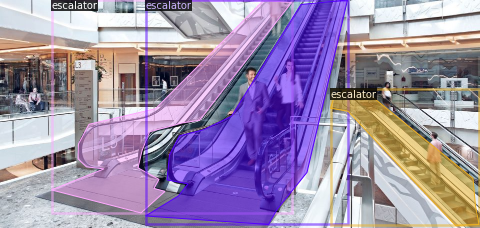

In [ ]:
import random
from detectron2.utils.visualizer import Visualizer

#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("door_train")
dataset_dicts = DatasetCatalog.get("door_train")

for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

#Configure & Train the model
Before we start training the model, there are a few configurations that must be done. Firstly, edit the *MODEL.ROI_HEADS.NUM_CLASSES* variable to the same number of classes that the dataset has. 

The variables that can be changed can be found in the *configs folder* in the Detectron2 folder that you have cloned earlier.  The config files houses all the default configurations for your model, and making changes in the *directly in the cell below will overwrite the default configuration.

The configurations of your model depends greatly on the kind of data you would like to train your model on. Hence, I am unable to give you a definite answer on what is the "best" configuration for your model. 

Lastly, we will fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the dataset. It takes ~30 minutes to 1.5 hours to train 2000+ iterations on Colab's GPU.


In [ ]:
#We are importing our own Trainer Module here to use the COCO validation evaluation during training. Otherwise no validation eval occurs.
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)


from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("door_train",)
cfg.DATASETS.VAL = ("door_val",)
cfg.DATASETS.TEST = ("door_test",)  
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")


cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4 # 4 classes (door, lift, stairs, escalator)
cfg.SOLVER.MAX_ITER = 1800 #adjust up if val mAP is still rising, adjust down if overfit


cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128

cfg.TEST.EVAL_PERIOD = 500

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=True) #continue training on top of coco checkpoint 
#trainer.train()

[08/04 11:08:51 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

#Save the Model


In [ ]:
from detectron2.modeling import build_model
import torch
model = build_model(cfg)
#torch.save(model.state_dict(), '/content/output/mrcnn.pth')

#Load the Model

To use the model for inference, 

In [ ]:
model.load_state_dict(torch.load( '/content/output/mrcnn.pth', map_location='cpu'))

#Evaluating the Model
Now, we perform inference with the trained model on the doorway dataset. First, let's create a predictor using the model we just trained. 



##Average Precision (AP) Values on Test Dataset

These values are important in showing how well the model is doing overall, and for each individual classes. This will be crucial in spotting any overfitting tendencies within the model, and how well it fairs with different IoU levels. You can read more about AP values and intersections over unions (IoU) [here](https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173). Usually, a score of around 80% for AP50 would be good enough for me. To improve on your accuracy, consider tweaking the configurations, or adding new data to your dataset.

In [ ]:
#test evaluation
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("door_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "door_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

[08/04 11:09:42 d2.data.datasets.coco]: Loaded 27 images in COCO format from /content/custom-data-with-mcrnn/dataset/predict_detectron2/annotations_detectron2.json
[08/04 11:09:42 d2.data.build]: Distribution of instances among all 4 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| escalator  | 13           |   stairs   | 9            |    door    | 9            |
|    lift    | 11           |            |              |            |              |
|   total    | 42           |            |              |            |              |
[08/04 11:09:42 d2.data.common]: Serializing 27 elements to byte tensors and concatenating them all ...
[08/04 11:09:42 d2.data.common]: Serialized dataset takes 0.01 MiB
[08/04 11:09:42 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='c

/usr/local/lib/python3.6/dist-packages/detectron2/layers/wrappers.py:226: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  return x.nonzero().unbind(1)


[08/04 11:09:45 d2.evaluation.evaluator]: Inference done 11/27. 0.1126 s / img. ETA=0:00:04
[08/04 11:09:50 d2.evaluation.evaluator]: Inference done 25/27. 0.1110 s / img. ETA=0:00:00
[08/04 11:09:51 d2.evaluation.evaluator]: Total inference time: 0:00:07.739068 (0.351776 s / img per device, on 1 devices)
[08/04 11:09:51 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.108715 s / img per device, on 1 devices)
[08/04 11:09:51 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[08/04 11:09:51 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[08/04 11:09:51 d2.evaluation.coco_evaluation]: Evaluating predictions ...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.01 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision

OrderedDict([('bbox',
              {'AP': 53.530927189761634,
               'AP-door': 50.87465679341043,
               'AP-escalator': 47.392582115354394,
               'AP-lift': 69.06274047734443,
               'AP-stairs': 46.79372937293729,
               'AP50': 82.5541434233921,
               'AP75': 60.7654707172398,
               'APl': 53.530927189761634,
               'APm': nan,
               'APs': nan}),
             ('segm',
              {'AP': 52.119652040753515,
               'AP-door': 51.62144785907162,
               'AP-escalator': 39.80920949237781,
               'AP-lift': 72.71131714819833,
               'AP-stairs': 44.33663366336633,
               'AP50': 76.34608511756153,
               'AP75': 55.0751516853366,
               'APl': 52.119652040753515,
               'APm': nan,
               'APs': nan})])

##Visual Evaluation on Test Dataset
Here, we randomly select several samples to visualize the prediction results.

In [ ]:
from detectron2.utils.visualizer import ColorMode

#switch to test dataset
my_dataset_test_metadata = MetadataCatalog.get("door_test")
dataset_dicts = DatasetCatalog.get("door_test")

for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=my_dataset_test_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Benchmark inference speed

In [ ]:
import time
times = []
for i in range(20):
    start_time = time.time()
    outputs = predictor(im)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec):{:.2f},fps:{:.2f}".format(mean_delta, fps))

Average(sec):0.39,fps:2.59
